[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/emiletimothy/Caltech-CS155-2023/blob/main/set5/set5_prob2.ipynb)


# Problem 2

In [67]:
import numpy as np

import pandas as pd

import torch
from torch.utils.data import DataLoader

from torchfm.dataset.movielens import MovieLens20MDataset
from torchfm.layer import FeaturesEmbedding, MultiLayerPerceptron

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
from adjustText import adjust_text

Redefine

In [68]:
class MovieLensDataset(torch.utils.data.Dataset):
    """
    MovieLens Dataset
    Data preparation
        treat samples with a rating less than 3 as negative samples
    :param dataset_path: MovieLens dataset path
    Reference:
        https://grouplens.org/datasets/movielens
    """

    def __init__(self, dataset_path, sep=',', engine='c', header='infer'):
        data = pd.read_csv(dataset_path, sep=sep, engine=engine, header=header).to_numpy()[:, :3]
        self.items = data[:, :2].astype(np.int)
        self.targets = data[:, 2].astype(np.float32)
        self.field_dims = np.max(self.items, axis=0) + 1
        self.user_field_idx = np.array((0, ), dtype=np.long)
        self.item_field_idx = np.array((1,), dtype=np.long)

    def __len__(self):
        return self.targets.shape[0]

    def __getitem__(self, index):
        return self.items[index], self.targets[index]

    def __preprocess_target(self, target):
        target[target <= 3] = 0
        target[target > 3] = 1
        return target

In [69]:
dataset = MovieLensDataset("../data.csv") 

C:\Users\maxwe\AppData\Local\Temp\ipykernel_32080\2639281332.py:13: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.items = data[:, :2].astype(np.int)
C:\Users\maxwe\AppData\Local\Temp\ipykernel_32080\2639281332.py:16: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by itself. In the likely event your code does not need to work on Python 2 you can use the builtin `int` for which `np.compat.long` is itself an alias. Doing this will not modify any behaviour and is safe. When

In [70]:
movies = pd.read_csv("../movies.csv")
data = pd.read_csv("../data.csv")
top_movies = pd.read_csv("../data.csv")
top_movies.sort_values("Rating", axis=0, ascending=False,inplace=True, na_position='first')
print(data)
print(top_movies)

        User ID  Movie ID  Rating
0             0        88     4.0
1             0       545     3.5
2             0         7     3.0
3             0       401     4.0
4             0      1230     0.5
...         ...       ...     ...
121496      991       681     1.0
121497      991       736     3.5
121498      991       162     3.0
121499      991      1242     3.5
121500      991       321     4.5

[121501 rows x 3 columns]
        User ID  Movie ID  Rating
47483       394      1355     5.0
70029       594       543     5.0
32801       274       902     5.0
32799       274       169     5.0
13287       113       650     5.0
...         ...       ...     ...
60735       504       554     0.5
60736       504       555     0.5
91259       751        52     0.5
112624      925       338     0.5
14650       127       957     0.5

[121501 rows x 3 columns]


In [71]:
Y = np.array(data)
print(Y)
print(len(Y))
random.shuffle(Y)
print(Y)

[[   0.    88.     4. ]
 [   0.   545.     3.5]
 [   0.     7.     3. ]
 ...
 [ 991.   162.     3. ]
 [ 991.  1242.     3.5]
 [ 991.   321.     4.5]]
121501
[[   0.    88.     4. ]
 [   0.    88.     4. ]
 [   0.   545.     3.5]
 ...
 [ 433.   116.     4. ]
 [ 960.   793.     3. ]
 [ 884.  1219.     4. ]]


In [72]:
from numpy.random.mtrand import gamma
def grad_U(Ui, Yij, Vj, Ai, Bj, reg, eta):
    """
    Takes as input Ui (the ith row of U), a training point Yij, the column
    vector Vj (jth column of V^T), the ith term of A , the jth term of B
    reg (the regularization parameter lambda),
    and eta (the learning rate).

    Returns the gradient of the regularized loss function with
    respect to Ui multiplied by eta.
    """
    sum = Vj*(Yij - (np.dot(Ui, Vj) + Ai + Bj))
    grad = reg*Ui-sum
    return eta*grad

def grad_V(Vj, Yij, Ui, Ai, Bj, reg, eta):
    """
    Takes as input Ui (the ith row of U), a training point Yij, the column
    vector Vj (jth column of V^T), the ith term of A , the jth term of B
    reg (the regularization parameter lambda),
    and eta (the learning rate).

    Returns the gradient of the regularized loss function with
    respect to Vj multiplied by eta.
    """
    sum = Ui*(Yij - (np.dot(Ui, Vj) + Ai + Bj))
    grad = reg*Vj-sum
    return eta*grad

def grad_A(Vj, Yij, Ui, Ai, Bj, eta): ############ NEW
    """
    Takes as input Ui (the ith row of U), a training point Yij, the column
    vector Vj (jth column of V^T), the ith term of A , the jth term of B
    reg (the regularization parameter lambda),
    and eta (the learning rate).

    Returns the gradient of the regularized loss function with
    respect to Ai multiplied by eta.
    """
    grad = -(Yij - (np.dot(Ui, Vj) + Ai + Bj))
    return eta*grad

def grad_B(Vj, Yij, Ui, Ai, Bj, eta): ############ NEW
    """
    Takes as input Ui (the ith row of U), a training point Yij, the column
    vector Vj (jth column of V^T), the ith term of A , the jth term of B
    reg (the regularization parameter lambda),
    and eta (the learning rate).

    Returns the gradient of the regularized loss function with
    respect to Bj multiplied by eta.
    """
    grad = -(Yij - (np.dot(Ui, Vj) + Ai + Bj))
    return eta*grad

def get_err(A, B, U, V, Y, reg=0.0):
    """
    Takes as input a matrix Y of triples (i, j, Y_ij) where i is the index of a user,
    j is the index of a movie, A is the biases for each user, 
    B is the list of biases for each movie, Y_ij is user i's rating of movie j, and
    user/movie matrices U and V.

    Returns the mean regularized squared-error of predictions made by
    estimating Y_{ij} as the dot product of the ith row of U and the jth column of V^T.
    """
    sum = 0
    for y in Y:
      i = int(y[0])
      j = int(y[1])
      Yij = y[2]
      sum += (Yij-(np.dot(U[i], V[j]) + A[i] + B[j]))**2
      
    return float(sum/(2*len(Y)))



def train_model(M, N, K, eta, reg, Y, eps=0.0001, max_epochs=1000):
    """
    Given a training data matrix Y containing rows (i, j, Y_ij)
    where Y_ij is user i's rating on movie j, learns an
    M x K matrix U and N x K matrix V such that rating Y_ij is approximated
    by (UV^T)_ij.

    Uses a learning rate of <eta> and regularization of <reg>. Stops after
    <max_epochs> epochs, or once the magnitude of the decrease in regularized
    MSE between epochs is smaller than a fraction <eps> of the decrease in
    MSE after the first epoch.

    Returns a tuple (U, V, err) consisting of U, V, and the unregularized MSE
    of the model.
    """
    U = np.random.uniform(low=-0.5, high=0.5, size=(M,K))
    V = np.random.uniform(low=-0.5, high=0.5, size=(N,K))
    A = np.random.uniform(low=-0.5, high=0.5, size=(M))
    B = np.random.uniform(low=-0.5, high=0.5, size=(N))
    e=0
    mse_0 = get_err(A, B, U, V, Y, reg)
    prev_mse = mse_0
    cur_mse = mse_0
    first_mse = 0
    first = True
    while e<max_epochs:
      np.random.shuffle(Y)
      for y in Y:
          #we tryna minimize error of UV^T and Y
        i = int(y[0]) #uxer
        j = int(y[1]) #movie
        Yij = y[2] #user's rating

        #build U and V using gradient descent
        ##### wouold we update the A and B here??
          #update the values for a specific user's movie pref params
        U[i] -= grad_U(U[i], Yij, V[j], A[i], B[j], reg, eta) 
          #update the values for a specific movie's relationships to users
        V[j] -= grad_V(V[j], Yij, U[i], A[i], B[j], reg, eta)

        A -= grad_A(V[j], Yij, U[i], A[i], B[j], eta) 
        B -= grad_B(V[j], Yij, U[i], A[i], B[j], eta)

      #obtain the error
      cur_mse = get_err(A, B, U, V, Y, reg)
      if(first):
        first_mse = mse_0-cur_mse
        first = False
      #stop when change in error gets too small
      if (prev_mse-cur_mse)<=(first_mse*eps):
        break

      prev_mse = cur_mse
      e += 1

    return U, V, A, B, cur_mse

In [73]:
Y_train = Y[0:109351]
Y_test = Y[109351:121501]

In [74]:

M = max(max(Y_train[:,0]), max(Y_test[:,0])).astype(int) # users
N = max(max(Y_train[:,1]), max(Y_test[:,1])).astype(int) # movies

M += 1
N += 1
print("Factorizing with ", M, " users, ", N, " movies.")
K = 20

reg = 0.0
eta = 0.03 # learning rate
E_in = []
E_out = []

# Use to compute Ein and Eout

U,V,A,B, err = train_model(M, N, K, eta, reg, Y_train)


Factorizing with  989  users,  1500  movies.


In [75]:

print(f"Testing error: {get_err(A, B, U, V, Y_test)}")

Testing error: 0.3838208373166797


Extract U 

## Preparing Data for Visualization
Run the cell below to get your graphs. This might take a long time to run, but it should take less than 2 hours. I would encourage you to validate your 2C is correct.

In [76]:
# Read movies.csv and make dict of movie titles to movie ids
movies = pd.read_csv("../movies.csv")
movie_titles = movies["Movie Title"].tolist()
movie_ids = movies["Movie ID"].tolist()
movie_dict = dict(zip(movie_titles, movie_ids))

# Make a list of movie IDs for each genre
action_ids = movies[movies["Action"] == 1]["Movie ID"].tolist()
adventure_ids = movies[movies["Adventure"] == 1]["Movie ID"].tolist()
animation_ids = movies[movies["Animation"] == 1]["Movie ID"].tolist()
children_ids = movies[movies["Children"] == 1]["Movie ID"].tolist()
comedy_ids = movies[movies["Comedy"] == 1]["Movie ID"].tolist()
crime_ids = movies[movies["Crime"] == 1]["Movie ID"].tolist()
documentary_ids = movies[movies["Documentary"] == 1]["Movie ID"].tolist()

In [77]:
# Count number of ratings for each movie by counting occurences of movie ids in dataset
movie_ratings = dataset.items[:,1]
movie_rating_counts = np.bincount(movie_ratings)

movie_avg_ratings = np.zeros(len(movie_rating_counts))
for i in range(len(movie_rating_counts)):
    movie_avg_ratings[i] = np.mean(dataset.targets[dataset.items[:,1] == i])

# Sort movies by number of ratings
popular_movie_ids = np.argsort(movie_rating_counts)[::-1]

# Sort movies by average rating
top_movie_ids = np.argsort(movie_avg_ratings)[::-1]

print("Top 10 movies by number of ratings:")
for i in range(10):
    movie_id = popular_movie_ids[i]
    print(f"{movie_titles[movie_id]}: {movie_rating_counts[movie_id]} ratings")

print()

print("Top 10 movies by average rating:")
for i in range(10):
    movie_id = top_movie_ids[i]
    print(f"{movie_titles[movie_id]}: {movie_avg_ratings[movie_id]} average rating")

Top 10 movies by number of ratings:
Lord of the Rings: The Fellowship of the Ring, The (2001): 747 ratings
Lord of the Rings: The Two Towers, The (2002): 713 ratings
Lord of the Rings: The Return of the King, The (2003): 698 ratings
Shrek (2001): 610 ratings
Pirates of the Caribbean: The Curse of the Black Pearl (2003): 585 ratings
Dark Knight, The (2008): 561 ratings
Finding Nemo (2003): 528 ratings
Kill Bill: Vol. 1 (2003): 520 ratings
Monsters, Inc. (2001): 519 ratings
Ocean's Eleven (2001): 517 ratings

Top 10 movies by average rating:
Planet Earth (2006): 4.467741966247559 average rating
Black Mirror: White Christmas (2014): 4.454545497894287 average rating
Akeelah and the Bee (2006): 4.300000190734863 average rating
Barbarian Invasions, The (Les invasions barbares) (2003): 4.275000095367432 average rating
Louis C.K.: Live at The Comedy Store (2015): 4.264705657958984 average rating
Blue Is the Warmest Color (La vie d'Adèle) (2013): 4.258620738983154 average rating
Elite Squad: Th

## Visualizations

In [80]:
# find top 10 similar movies to something
movie_id = movie_dict["Finding Nemo (2003)"]
vec = V[movie_id]

# Find cosine similarity between movie and all other movies
cosine_sim = np.dot(V, vec) / (np.linalg.norm(V, axis=1) * np.linalg.norm(vec))
top_10 = np.argsort(cosine_sim)[:-20:-1]

for id in top_10:
    print(movie_titles[id])

Finding Nemo (2003)
Shrek (2001)
Bandits (2001)
Incredibles, The (2004)
Hotel Rwanda (2004)
Elite Squad (Tropa de Elite) (2007)
Cold Mountain (2003)
Lone Survivor (2013)
Lives of Others, The (Das leben der Anderen) (2006)
Ocean's Eleven (2001)
Enron: The Smartest Guys in the Room (2005)
Seabiscuit (2003)
Brave (2012)
Superbad (2007)
Corpse Bride (2005)
Station Agent, The (2003)
Life of David Gale, The (2003)
Exit Through the Gift Shop (2010)
Louis C.K.: Live at the Beacon Theater (2011)


(20, 1500) (20, 20)
(2, 1500)
10


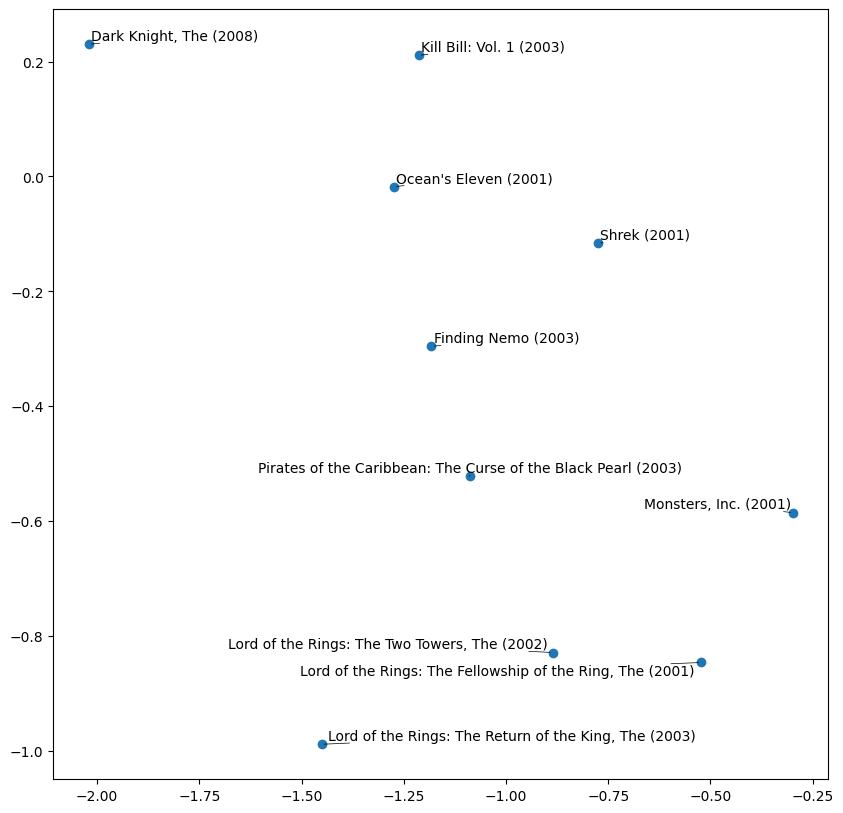

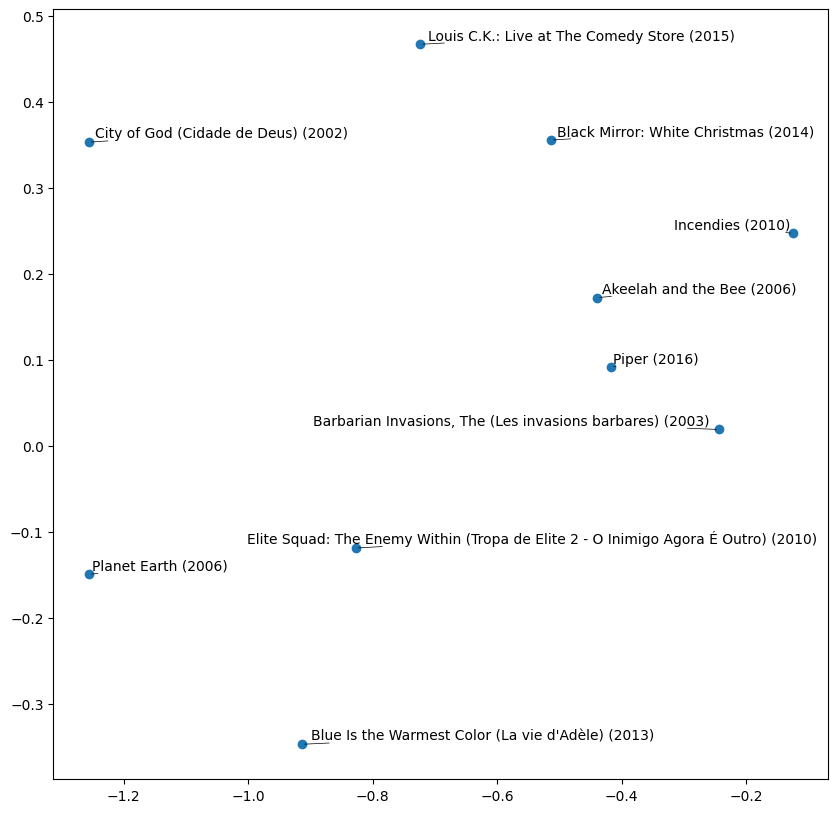

In [84]:
# Compute SVD of movie_embedding
V = V.T  # put movies on columns
V -= np.mean(V, axis=0) # subtract mean

A, s, B = np.linalg.svd(V, full_matrices=False)

print(V.shape, A.shape)
movie_projected = A[:, :2].T @ V
print(movie_projected.shape)

# Plot the first 2 principal components of the movie embedding for the 10 most popular movies
n_movies = 10

%config InlineBackend.print_figure_kwargs = {'facecolor' : "w"}

def plot_svd(movie_list, filename=None):
    plt.figure(figsize=(10, 10))
    var = plt.scatter(movie_projected[0, movie_list], movie_projected[1, movie_list])
    texts = [plt.text(movie_projected[0, id], movie_projected[1, id], movie_titles[id]) for id in movie_list]
    adjust_text(texts, arrowprops=dict(arrowstyle="-", color='k', lw=0.5))

    if filename is not None:
        plt.savefig(filename, dpi=300, bbox_inches="tight", facecolor="w")

    plt.show()
print(n_movies)
plot_svd(popular_movie_ids[:n_movies], "popular_movies.png")
plot_svd(top_movie_ids[:n_movies], "top_movies.png")